* 구글 드라이브 내에서 실행하는 폴더 및 파일을 압축하여 메일에 함께 첨부했습니다.  
* EDA 및 모델 구현은 Colab 무료버전에서 실행했습니다.  
* 첨부한 압축파일을 압축해제하여, 구글 드라이브에 업로드 한 후, 실행할 수 있습니다.  




In [ ]:
# 구글 드라이브에 저장된 파일을 사용하기 위한 코드
from google.colab import drive
drive.mount('/content/drive')

# 저장된 파일의 경로 설정
%cd /content/drive/MyDrive/LG 해커톤/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/LG 해커톤


# Import Library

In [ ]:
# 필요한 라이브러리 불러오기
import random
import math
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# EDA

## 매출에 큰 영향을 미치는 제품 분석

### 전체 제품 기준

In [ ]:
df = pd.read_csv("data/train.csv")

# Drop non-sales related columns to focus on the sales data
sales_data = df.drop(columns=['ID', '제품', '대분류', '중분류', '소분류', '브랜드'])

# Transpose the DataFrame to have dates as rows and products as columns
sales_data_transposed = sales_data.transpose()

# Calculate daily sales ranks for each product
daily_sales_ranks = sales_data_transposed.rank(axis=1, ascending=False, method='min')

# Calculate the daily total sales
daily_total_sales = sales_data_transposed.sum(axis=1)

# Calculate the 80% threshold for daily total sales
eighty_percent_threshold = daily_total_sales * 0.8

# Initialize a dictionary to store the rank corresponding to the 80% threshold for each day
ranks_at_80_percent = {}

# Loop through each day to find the rank that corresponds to the 80% threshold
for date, threshold in eighty_percent_threshold.iteritems():
    # Get the sorted daily sales for the date
    sorted_daily_sales = sales_data_transposed.loc[date].sort_values(ascending=False)

    # Calculate the cumulative sum of the sorted daily sales
    cumulative_sales = sorted_daily_sales.cumsum()

    # Find the rank at which the cumulative sales exceed or meet the 80% threshold
    rank_at_80_percent = cumulative_sales[cumulative_sales >= threshold].index[0] + 1  # Adding 1 because index starts at 0

    # Store the result in the dictionary
    ranks_at_80_percent[date] = rank_at_80_percent

# Convert the dictionary to a DataFrame for better visualization
df_ranks_at_80_percent = pd.DataFrame(list(ranks_at_80_percent.items()), columns=['Date', 'Rank at 80% Threshold'])

# Show the first few rows of the resulting DataFrame
df_ranks_at_80_percent.head()

<ipython-input-67-c2d1a423ff87>:22: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for date, threshold in eighty_percent_threshold.iteritems():


,Date,Rank at 80% Threshold
0,2022-01-01,6470
1,2022-01-02,1418
2,2022-01-03,3106
3,2022-01-04,10302
4,2022-01-05,14444


In [ ]:
# Initialize a dictionary to store the percentage of total daily sales contributed by the top 20% products for each day
percentage_by_top_20 = {}

# Loop through each day to find the percentage of total daily sales contributed by the top 20% products
for date, total_sales in daily_total_sales.iteritems():
    # Get the sorted daily sales for the date
    sorted_daily_sales = sales_data_transposed.loc[date].sort_values(ascending=False)

    # Calculate the number of top 20% products
    num_top_20_products = int(len(sorted_daily_sales) * 0.2)

    # Get the sales of the top 20% products and sum them up
    top_20_sales_sum = sorted_daily_sales.head(num_top_20_products).sum()

    # Calculate the percentage of total daily sales contributed by the top 20% products
    percentage = (top_20_sales_sum / total_sales) * 100 if total_sales != 0 else 0

    # Store the result in the dictionary
    percentage_by_top_20[date] = percentage

# Convert the dictionary to a DataFrame for better visualization
df_percentage_by_top_20 = pd.DataFrame(list(percentage_by_top_20.items()), columns=['Date', 'Percentage by Top 20%'])

# Show the first few rows of the resulting DataFrame
df_percentage_by_top_20.head()

<ipython-input-68-4bafebe6b382>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for date, total_sales in daily_total_sales.iteritems():


,Date,Percentage by Top 20%
0,2022-01-01,99.685031
1,2022-01-02,99.695571
2,2022-01-03,99.592230
3,2022-01-04,99.319383
4,2022-01-05,98.937288


In [ ]:
# Calculate the average percentage of total daily sales contributed by the top 20% products
average_percentage_by_top_20 = df_percentage_by_top_20['Percentage by Top 20%'].mean()
average_percentage_by_top_20

97.24151382506072

* 그래프 시각화

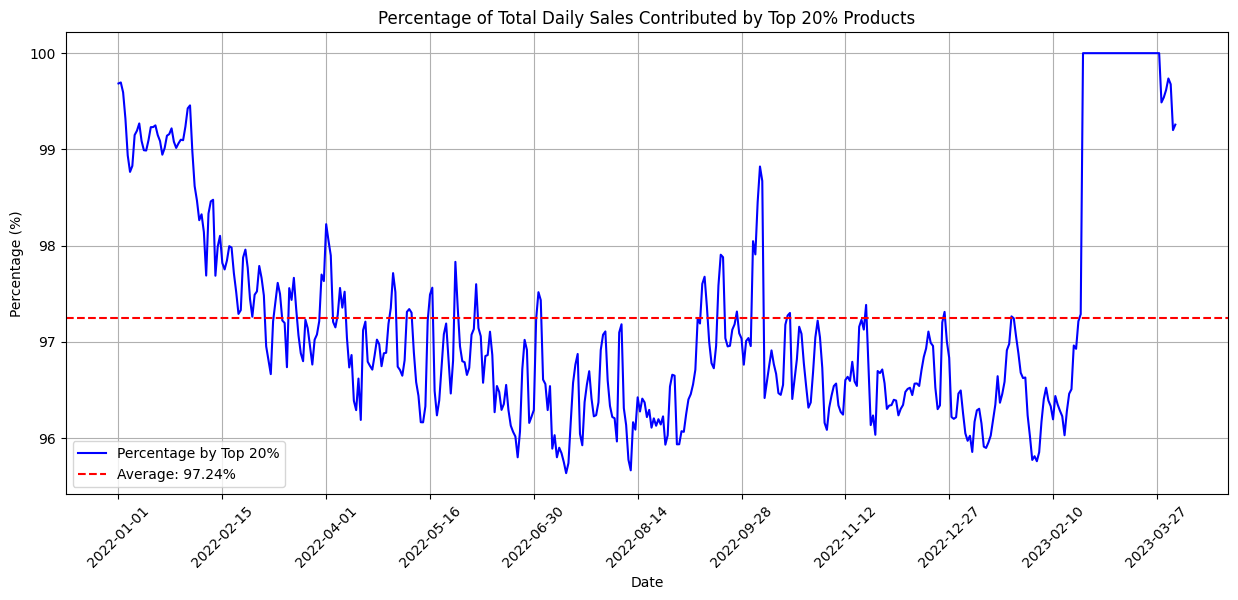

In [ ]:
# Plotting the data
plt.figure(figsize=(15, 6))
plt.plot(df_percentage_by_top_20['Date'], df_percentage_by_top_20['Percentage by Top 20%'], label='Percentage by Top 20%', color='blue')
plt.axhline(y=average_percentage_by_top_20, color='r', linestyle='--', label=f'Average: {average_percentage_by_top_20:.2f}%')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Total Daily Sales Contributed by Top 20% Products')
plt.legend()
plt.grid(True)
plt.xticks(df_percentage_by_top_20['Date'][::int(len(df_percentage_by_top_20)/10)], rotation=45)  # Show only a subset of dates for readability
plt.show()

위의 그래프는 2022년 1월 1일부터 2023년 4월 4일까지 상위 20%의 제품이 전체 일별 매출에 차지하는 비율을 나타냅니다. 빨간색 점선은 해당 기간 동안의 평균 비율 (약 97.24)을 표시합니다.

일별, 전체 매출의 약 97&는 전체 제품의 20%가 기여하고 있다.

### 대분류별 기준(일별)

In [ ]:
# Initialize a dictionary to store the average percentage of total daily sales contributed by the top 20% products for each 대분류
average_percentage_by_top_20_per_category = {}

# Get unique 대분류 categories
unique_categories = df['대분류'].unique()

# Loop through each 대분류 to calculate the required metrics
for category in unique_categories:
    # Filter the DataFrame to only include rows corresponding to the current 대분류
    df_filtered = df[df['대분류'] == category]

    # Drop non-sales related columns to focus on the sales data
    sales_data_filtered = df_filtered.drop(columns=['ID', '제품', '대분류', '중분류', '소분류', '브랜드'])

    # Transpose the DataFrame to have dates as rows and products as columns
    sales_data_filtered_transposed = sales_data_filtered.transpose()

    # Calculate the daily total sales for the filtered data
    daily_total_sales_filtered = sales_data_filtered_transposed.sum(axis=1)

    # Initialize a list to store the daily percentages for the current 대분류
    daily_percentages = []

    # Loop through each day to find the percentage of total daily sales contributed by the top 20% products
    for date, total_sales in daily_total_sales_filtered.iteritems():
        # Get the sorted daily sales for the date
        sorted_daily_sales = sales_data_filtered_transposed.loc[date].sort_values(ascending=False)

        # Calculate the number of top 20% products
        num_top_20_products = int(len(sorted_daily_sales) * 0.2)

        # Get the sales of the top 20% products and sum them up
        top_20_sales_sum = sorted_daily_sales.head(num_top_20_products).sum()

        # Calculate the percentage of total daily sales contributed by the top 20% products
        percentage = (top_20_sales_sum / total_sales) * 100 if total_sales != 0 else 0

        # Append the percentage to the list
        daily_percentages.append(percentage)

    # Calculate the average percentage for the current 대분류 and store it in the dictionary
    average_percentage_by_top_20_per_category[category] = sum(daily_percentages) / len(daily_percentages)

# Convert the dictionary to a DataFrame for better visualization
df_average_percentage_by_top_20_per_category = pd.DataFrame(list(average_percentage_by_top_20_per_category.items()), columns=['대분류', 'Average Percentage by Top 20%'])

df_average_percentage_by_top_20_per_category

<ipython-input-71-115d9bdcc3f3>:25: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for date, total_sales in daily_total_sales_filtered.iteritems():
<ipython-input-71-115d9bdcc3f3>:25: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for date, total_sales in daily_total_sales_filtered.iteritems():
<ipython-input-71-115d9bdcc3f3>:25: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for date, total_sales in daily_total_sales_filtered.iteritems():
<ipython-input-71-115d9bdcc3f3>:25: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for date, total_sales in daily_total_sales_filtered.iteritems():
<ipython-input-71-115d9bdcc3f3>:25: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for date, total_sales in daily_total_sales_filtere

,대분류,Average Percentage by Top 20%
0,B002-C001-0002,97.733253
1,B002-C001-0003,87.780707
2,B002-C001-0001,95.820147
3,B002-C001-0005,96.292769
4,B002-C001-0004,94.655465


### 대분류 기준(전체 기간)

In [ ]:
# Calculate the total sales for each product
df['Total_Sales'] = df.iloc[:, 6:-1].sum(axis=1)  # Exclude the '상위 20% 브랜드' column if it exists

# Initialize a dictionary to store the percentage of total sales contributed by the top 20% products for each 대분류
percentage_by_top_20_per_category = {}

# Calculate the 80th percentile of Total_Sales for each '대분류'
top_20_thresholds = df.groupby('대분류')['Total_Sales'].quantile(0.8)

# Loop through each 대분류 to calculate the required metrics
for category, threshold in top_20_thresholds.iteritems():
    # Filter the DataFrame to only include rows corresponding to the current 대분류
    df_filtered = df[df['대분류'] == category]

    # Calculate the total sales for the filtered DataFrame
    total_sales_filtered = df_filtered['Total_Sales'].sum()

    # Get the total sales of the top 20% products within the filtered DataFrame
    top_20_sales_filtered = df_filtered[df_filtered['Total_Sales'] > threshold]['Total_Sales'].sum()

    # Calculate the percentage of total sales contributed by the top 20% products
    percentage = (top_20_sales_filtered / total_sales_filtered) * 100 if total_sales_filtered != 0 else 0

    # Store the result in the dictionary
    percentage_by_top_20_per_category[category] = percentage

# Convert the dictionary to a DataFrame for better visualization
df_percentage_by_top_20_per_category = pd.DataFrame(list(percentage_by_top_20_per_category.items()), columns=['대분류', 'Percentage by Top 20%'])

# Drop the temporary 'Total_Sales' column
df = df.drop(columns=['Total_Sales'])

df_percentage_by_top_20_per_category

<ipython-input-72-24d7e8e8046b>:11: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for category, threshold in top_20_thresholds.iteritems():


,대분류,Percentage by Top 20%
0,B002-C001-0001,90.962527
1,B002-C001-0002,92.803023
2,B002-C001-0003,74.560625
3,B002-C001-0004,69.097902
4,B002-C001-0005,88.030252


각 '대분류' 내에서 상위 20%에 속하는 제품을 식별하고, 그 정보를 '상위 20% 브랜드' 열에 표시합니다. 이를 통해 각 '대분류' 내에서 높은 판매량을 기록한 제품을 쉽게 확인할 수 있습니다.

전체 기간 동안 각 대분류 내에서 상위 20%에 속하는 제품이 차지하는 매출 비율은 다음과 같습니다:  

대분류 B002-C001-0001: 약 90.96%  
대분류 B002-C001-0002: 약 92.80%  
대분류 B002-C001-0003: 약 74.56%  
대분류 B002-C001-0004: 약 69.10%  
대분류 B002-C001-0005: 약 88.03%  

평균 : 82.69%  
약 80%의 매출을 차지한다고 판단할 수 있습니다.

## 월별 판매량 분석

In [ ]:
# Load the data
data = pd.read_csv("data/train.csv")

# '소분류' 마다 '제품'의 종류가 얼마나 있는지 확인

# Count the unique '제품' within each '소분류'
product_counts = data.groupby('소분류')['제품'].nunique()

# Show the result
product_counts

소분류
B002-C003-0001     750
B002-C003-0002     659
B002-C003-0003    1422
B002-C003-0004     426
B002-C003-0005     342
B002-C003-0006     175
B002-C003-0007     262
B002-C003-0008     112
B002-C003-0009     183
B002-C003-0010     113
B002-C003-0011     101
B002-C003-0012      75
B002-C003-0013     104
B002-C003-0014     236
B002-C003-0015     465
B002-C003-0016     342
B002-C003-0017     222
B002-C003-0018      71
B002-C003-0019     140
B002-C003-0020     112
B002-C003-0021     195
B002-C003-0022     353
B002-C003-0023     364
B002-C003-0024     289
B002-C003-0025     689
B002-C003-0026     150
B002-C003-0027     408
B002-C003-0028     174
B002-C003-0029     198
B002-C003-0030     153
B002-C003-0031      57
B002-C003-0032     265
B002-C003-0033     180
B002-C003-0034    1020
B002-C003-0035     641
B002-C003-0036     362
B002-C003-0037     184
B002-C003-0038     431
B002-C003-0039     431
B002-C003-0040     451
B002-C003-0041     366
B002-C003-0042      59
B002-C003-0043     117
B002-C0

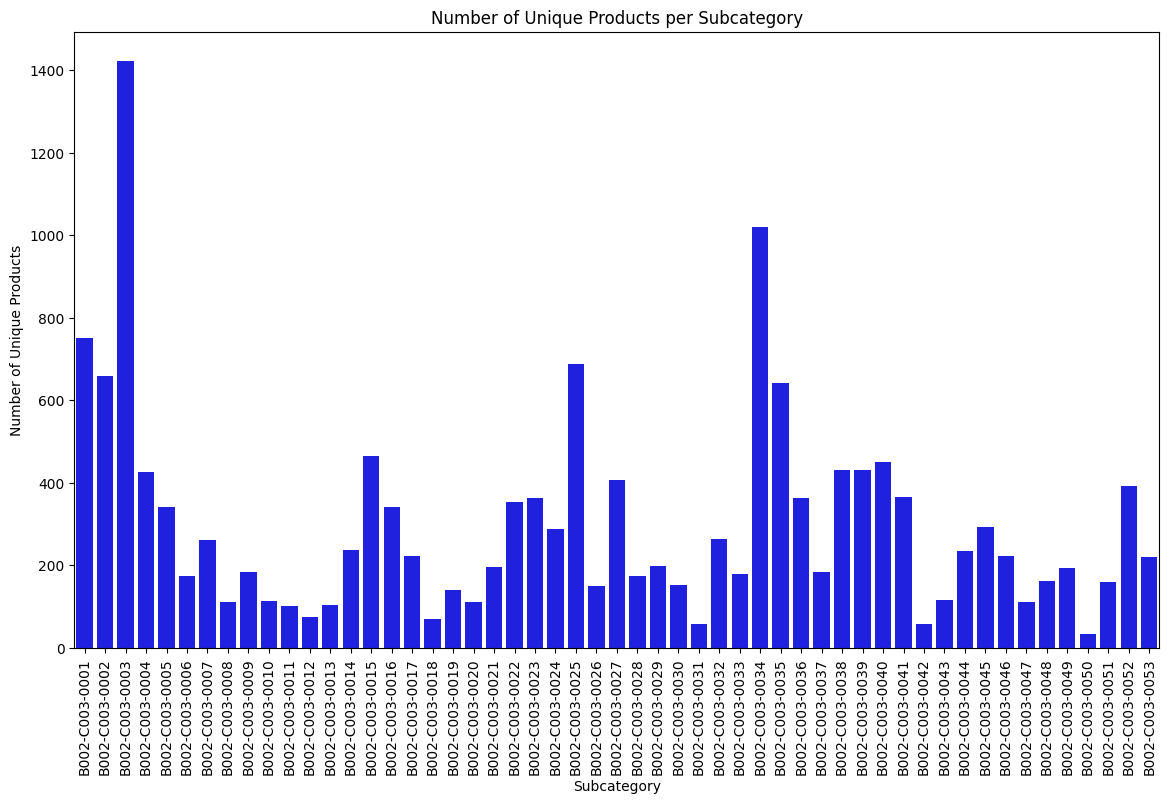

In [ ]:
# Set figure size
plt.figure(figsize=(14,8))

# Create bar plot
sns.barplot(x=product_counts.index, y=product_counts.values, color='b')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Set title and labels
plt.title('Number of Unique Products per Subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Number of Unique Products')

plt.show()

In [ ]:
# 월별 판매량을 확인

# Extract the date columns
date_columns = data.columns[6:]

# Convert the column names to datetime
dates = pd.to_datetime(date_columns)

# Transpose the data and set the dates as the index
sales_data = data[date_columns].T
sales_data.index = dates

# Resample the data to monthly frequency and sum the sales
monthly_sales = sales_data.resample('M').sum()

# Transpose the data back to the original form
monthly_sales = monthly_sales.T
monthly_sales = monthly_sales.iloc[:,:-1]

# Show the first few rows
monthly_sales.head()

,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31
0,0,9,3,23,32,0,0,0,1,39,32,61,93,50,0
1,3,0,69,139,73,95,69,38,18,17,1,0,38,20,6
2,0,12,96,211,120,160,156,113,33,51,29,37,19,0,0
3,4,245,140,414,156,212,175,98,39,70,32,3,0,0,0
4,6,25,169,214,2,0,0,0,0,82,382,202,70,73,0


### 월별 판매량 Top5는 계속해서 변하는가?

* 제품별로 분석

In [ ]:
# Add the '제품' column to the 'monthly_sales' dataframe
monthly_sales['제품'] = data['제품']

# For each month, sort the products by sales and select the top 5
top_5_products_monthly = monthly_sales.set_index('제품').apply(lambda x: x.nlargest(5).index.tolist())

# Transpose the result for better readability
top_5_products_monthly = top_5_products_monthly.T

# Show the result
top_5_products_monthly

,0,1,2,3,4
2022-01-31 00:00:00,B002-01069-00002,B002-00113-00001,B002-02723-00004,B002-00894-00140,B002-01069-00003
2022-02-28 00:00:00,B002-02920-00009,B002-02920-00005,B002-00113-00001,B002-02920-00020,B002-02723-00004
2022-03-31 00:00:00,B002-02920-00005,B002-02920-00009,B002-00113-00001,B002-02920-00020,B002-01069-00002
2022-04-30 00:00:00,B002-02920-00005,B002-00113-00001,B002-02920-00016,B002-01069-00002,B002-02920-00008
2022-05-31 00:00:00,B002-00113-00001,B002-02920-00016,B002-01755-00003,B002-01069-00002,B002-02723-00004
2022-06-30 00:00:00,B002-00113-00001,B002-02920-00016,B002-02920-00008,B002-02723-00004,B002-01069-00002
2022-07-31 00:00:00,B002-02920-00016,B002-00113-00001,B002-02723-00004,B002-00894-00036,B002-02525-00012
2022-08-31 00:00:00,B002-01755-00003,B002-02723-00004,B002-00113-00001,B002-02525-00012,B002-02783-00004
2022-09-30 00:00:00,B002-02723-00004,B002-00113-00001,B002-01069-00002,B002-03436-00017,B002-02783-00004
2022-10-31 00:00:00,B002-02920-00005,B002-02920-00004,B002-02920-00025,B002-02723-00004,B002-00809-00002


* 소분류별로 분석

In [ ]:
# Add the '소분류' column to the 'monthly_sales' dataframe
monthly_sales['소분류'] = data['소분류']

# For each month, group by '소분류', sum the sales, sort by the sum, and select the top 5
top_5_subcategories_monthly = monthly_sales.groupby('소분류').sum().apply(lambda x: x.nlargest(5).index.tolist())

# Transpose the result for better readability
top_5_subcategories_monthly = top_5_subcategories_monthly.T

# Show the result
top_5_subcategories_monthly

<ipython-input-77-7e71f8691a03>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_5_subcategories_monthly = monthly_sales.groupby('소분류').sum().apply(lambda x: x.nlargest(5).index.tolist())


,0,1,2,3,4
2022-01-31 00:00:00,B002-C003-0041,B002-C003-0003,B002-C003-0025,B002-C003-0004,B002-C003-0001
2022-02-28 00:00:00,B002-C003-0041,B002-C003-0025,B002-C003-0003,B002-C003-0004,B002-C003-0001
2022-03-31 00:00:00,B002-C003-0041,B002-C003-0025,B002-C003-0003,B002-C003-0004,B002-C003-0001
2022-04-30 00:00:00,B002-C003-0041,B002-C003-0025,B002-C003-0003,B002-C003-0004,B002-C003-0001
2022-05-31 00:00:00,B002-C003-0041,B002-C003-0025,B002-C003-0003,B002-C003-0004,B002-C003-0001
2022-06-30 00:00:00,B002-C003-0041,B002-C003-0025,B002-C003-0003,B002-C003-0004,B002-C003-0001
2022-07-31 00:00:00,B002-C003-0041,B002-C003-0025,B002-C003-0003,B002-C003-0004,B002-C003-0001
2022-08-31 00:00:00,B002-C003-0025,B002-C003-0041,B002-C003-0003,B002-C003-0004,B002-C003-0001
2022-09-30 00:00:00,B002-C003-0025,B002-C003-0041,B002-C003-0003,B002-C003-0004,B002-C003-0001
2022-10-31 00:00:00,B002-C003-0041,B002-C003-0025,B002-C003-0003,B002-C003-0004,B002-C003-0001


- 0041, 0003, 0025, 0004는 Top 4에 꾸준하게 등장하고 있다.
    
    **제품 특성**을 확인해서 어떤 상품인지 확인했다.
    
    0041 : **`유아용 귀저귀`**
    
    0003 : **`영양제(건강식품)`**
    
    0025 : `**물티슈**`
    
    0004 : **`단백질보충제`**
    
- 0001**`(건강기능식품)`** : 2022년 12월 이후, 순위권에서 사라진다.
    
    January 2023: 7th
    
    February 2023: 6th
    
    March 2023: 6th
    
    → 꾸준하게 감소하고 있다.
    
- 0052**`(유아 식품)`** : 2022년 12월 이후, 순위권에 등장!
    
    January 2022: 8th
    
    February 2022: 8th
    
    March 2022: 7th
    
    April 2022: 6th
    
    May 2022: 7th
    
    June 2022: 7th
    
    July 2022: 6th
    
    August 2022: 6th
    
    September 2022: 6th
    
    October 2022: 6th
    
    November 2022: 7th
    
    December 2022: 5th

### 분류 내에서 판매량 Top 5인 소분류를 확인

In [ ]:
# Add the '대분류' column to the 'monthly_sales' dataframe
monthly_sales['대분류'] = data['대분류']

# For each '대분류', group by '소분류', sum the sales, sort by the sum, and select the top 5
top_5_subcategories_in_major_category = monthly_sales.groupby(['대분류', '소분류']).sum().sum(axis=1).groupby(level=0).nlargest(5)

# Show the result
top_5_subcategories_in_major_category

<ipython-input-78-5c55c408229f>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_5_subcategories_in_major_category = monthly_sales.groupby(['대분류', '소분류']).sum().sum(axis=1).groupby(level=0).nlargest(5)


대분류             대분류             소분류           
B002-C001-0001  B002-C001-0001  B002-C003-0003    14195308
                                B002-C003-0004    10594712
                                B002-C003-0001     4895189
                                B002-C003-0002     3371034
                                B002-C003-0005     1203687
B002-C001-0002  B002-C001-0002  B002-C003-0041    28544745
                                B002-C003-0025    21015268
                                B002-C003-0023     2973591
                                B002-C003-0022     2751825
                                B002-C003-0034     2360064
B002-C001-0003  B002-C001-0003  B002-C003-0044      511144
                                B002-C003-0043      406312
                                B002-C003-0042      122944
                                B002-C003-0050       31409
B002-C001-0004  B002-C001-0004  B002-C003-0047       84993
B002-C001-0005  B002-C001-0005  B002-C003-0052     4066571
         

- 15개월 동안 꾸준하게 잘 팔리는 베스트 상품 4가지를 발견
    
    귀저귀 영양제 물티슈 단백질보충제

## 시계열 데이터 패턴 추출

In [ ]:
df_raw = pd.read_csv('data/train.csv')

In [ ]:
# Transpose the dataframe so that dates are the index and products are the columns
sales_data = df_raw.drop(['ID', '대분류', '중분류', '소분류', '브랜드'], axis=1).set_index('제품').transpose()

# Convert the index to datetime
sales_data.index = pd.to_datetime(sales_data.index)

# Sum the sales data by month
monthly_sales_data = sales_data.resample('M').sum()

monthly_sales_data.transpose()
df_month = monthly_sales_data.reset_index()
df_month.rename(columns = {'index' : 'date'}, inplace = True)
df_month.rename(columns = {'제품' : 'Index'}, inplace = True)

In [ ]:
# additive model: trend + cycle + seasonality + irregular factor

timestamp = np.arange(len(df_month))

trend_factor = timestamp*1.1

cycle_factor = 10*np.sin(np.linspace(0, 3.14*2, 16))

seasonal_factor = 7*np.sin(np.linspace(0, 3.14*8, 16))

np.random.seed(2004)

irregular_factor = 2*np.random.randn(len(df_month))



df = pd.DataFrame({'timeseries': trend_factor + cycle_factor + seasonal_factor + irregular_factor,

                   'trend': trend_factor,

                   'cycle': cycle_factor,

                   'seasonal': seasonal_factor,

                   'irregular': irregular_factor},

                   index=df_month['date'])

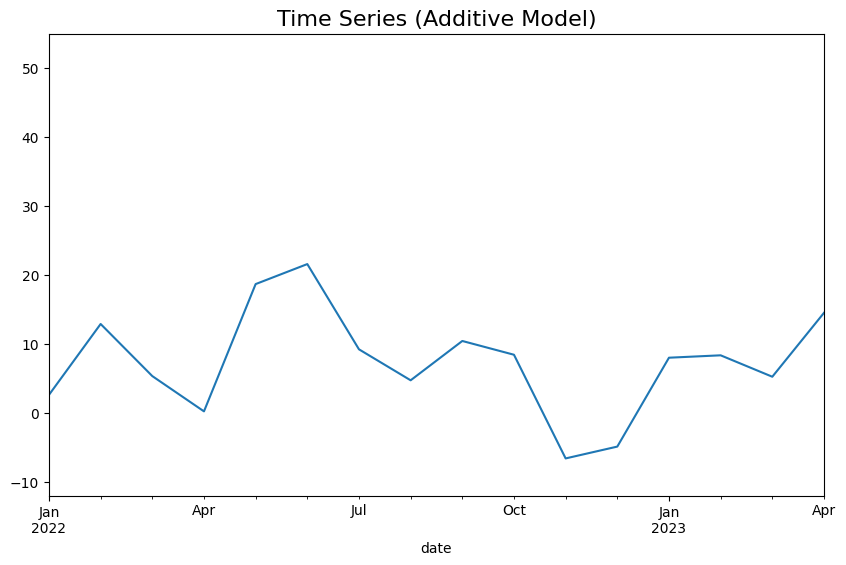

In [ ]:
# Time series plot

import matplotlib.pyplot as plt



plt.figure(figsize=[10, 6])

df.timeseries.plot()

plt.title('Time Series (Additive Model)', fontsize=16)

plt.ylim(-12, 55)

plt.show()

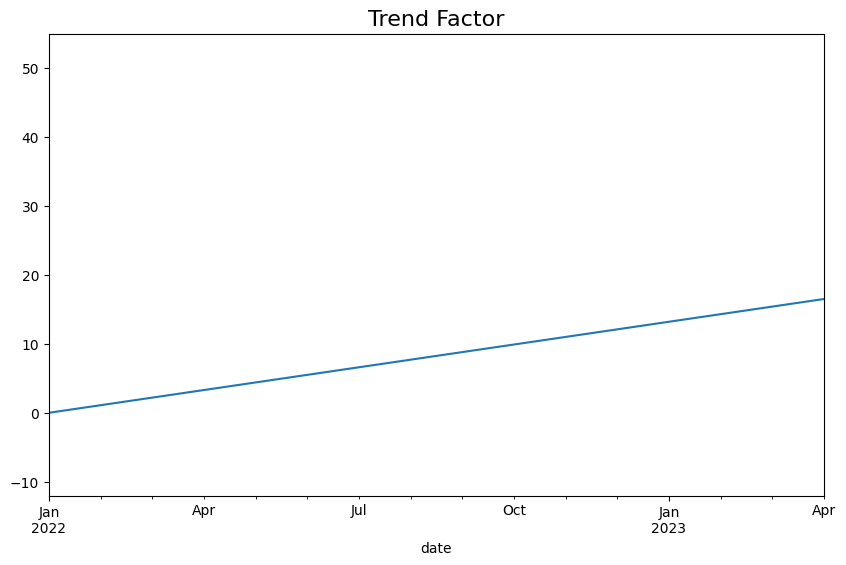

In [ ]:
# -- Trend factor

#timestamp = np.arange(len(dates))

#trend_factor = timestamp*1.1



plt.figure(figsize=[10, 6])

df.trend.plot()

plt.title('Trend Factor', fontsize=16)

plt.ylim(-12, 55)

plt.show()

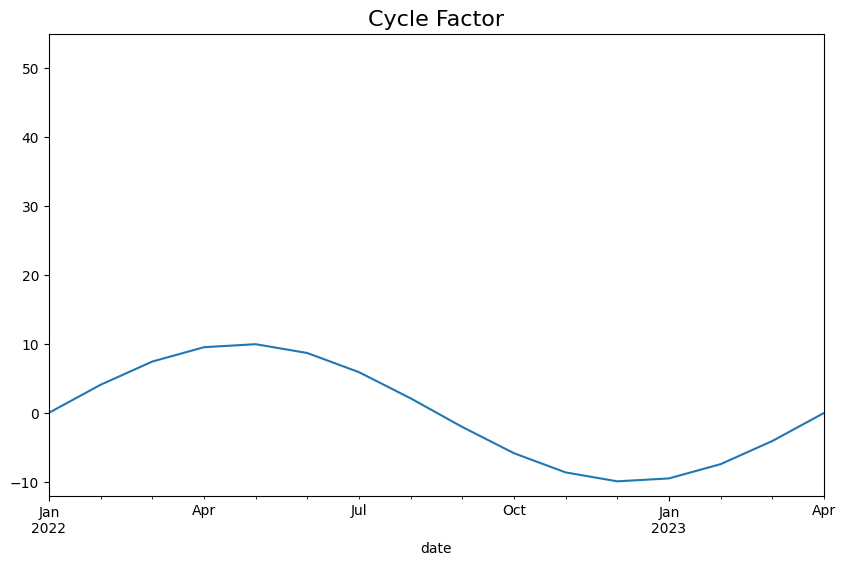

In [ ]:
# -- Cycle factor

#cycle_factor = 10*np.sin(np.linspace(0, 3.14*2, 16))



plt.figure(figsize=[10, 6])

df.cycle.plot()

plt.title('Cycle Factor', fontsize=16)

plt.ylim(-12, 55)

plt.show()

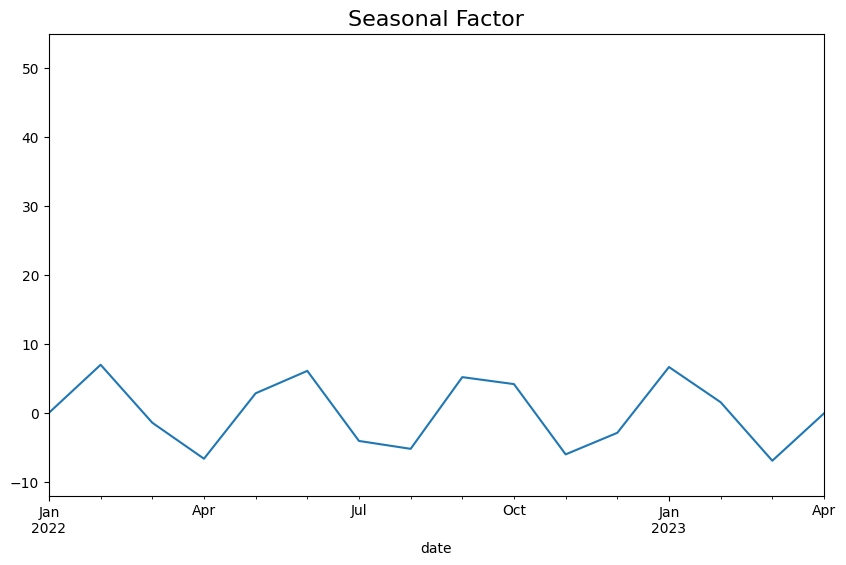

In [ ]:
# -- Seasonal factor

#seasonal_factor = 7*np.sin(np.linspace(0, 3.14*8, 16))



plt.figure(figsize=[10, 6])

df.seasonal.plot()

plt.title('Seasonal Factor', fontsize=16)

plt.ylim(-12, 55)

plt.show()

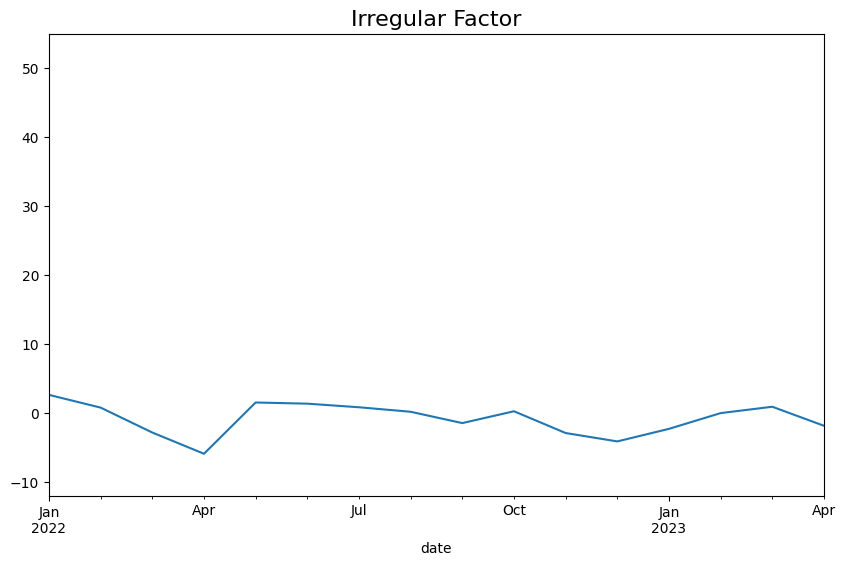

In [ ]:
# -- Irregular/ Random factor

#np.random.seed(2004)

#irregular_factor = 2*np.random.randn(len(dates))



plt.figure(figsize=[10, 6])

df.irregular.plot()

plt.title('Irregular Factor', fontsize=16)

plt.ylim(-12, 55)

plt.show()

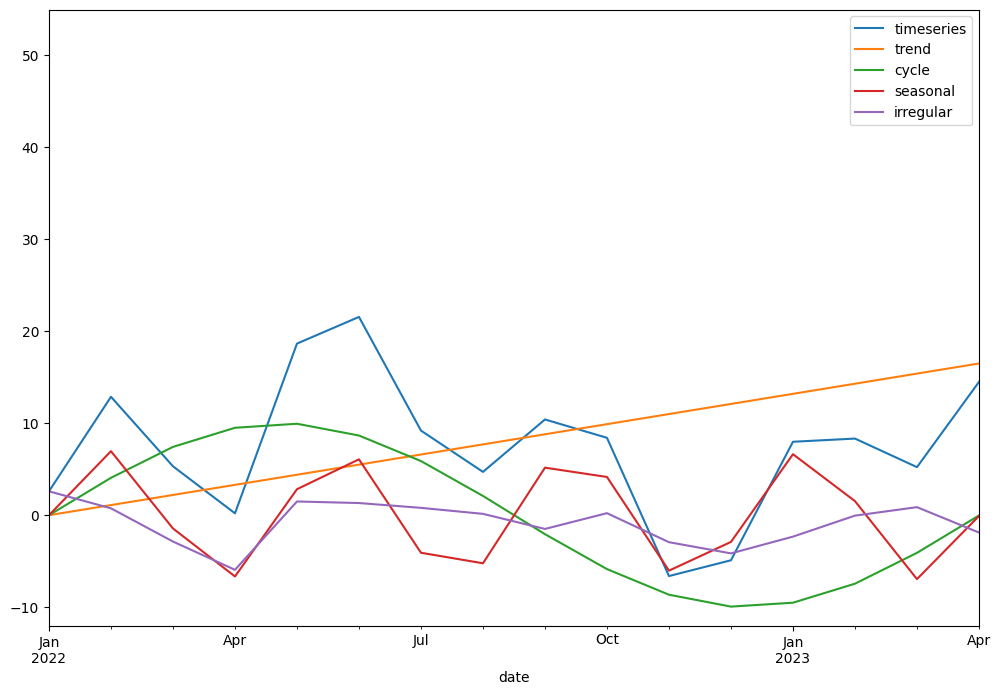

In [ ]:
# All in one: Time series = Trend factor + Cycle factor + Seasonal factor + Irregular factor


from pylab import rcParams

rcParams['figure.figsize'] = 12, 8

df.plot()

plt.ylim(-12, 55)

plt.show()

# processing(파생변수 생성)

### 상위 20% 브랜드 컬럼

In [ ]:
# Load the data
df = pd.read_csv('data/train.csv')

# Calculate the total sales for each product
df['Total_Sales'] = df.iloc[:, 6:].sum(axis=1)

# Create a new column for "Top 20% Brand" and set default value to 'no'
df['상위 20% 브랜드'] = 'no'

# Calculate the 80th percentile of Total_Sales for each '대분류'
top_20_thresholds = df.groupby('대분류')['Total_Sales'].quantile(0.8)

# Set '상위 20% 브랜드' to 'yes' for products in the top 20% within their '대분류'
for category, threshold in top_20_thresholds.iteritems():
    df.loc[(df['대분류'] == category) & (df['Total_Sales'] > threshold), '상위 20% 브랜드'] = 'yes'

# Drop the temporary 'Total_Sales' column
df = df.drop(columns=['Total_Sales'])

# Move the '상위 20% 브랜드' column to the right of the '브랜드' column
cols = df.columns.tolist()
cols.insert(cols.index('브랜드')+1, cols.pop(cols.index('상위 20% 브랜드')))
df = df[cols]

# Save the updated dataframe to a new CSV file again
df.to_csv('data/train_TopBrand.csv', index=False)

<ipython-input-88-7fc4a57c378b>:14: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for category, threshold in top_20_thresholds.iteritems():


### 제품특성 컬럼

In [ ]:
# Load the data (train_TopBrand와 product_info file load)
train = pd.read_csv("data/train_TopBrand.csv",index_col='ID')
product = pd.read_csv("data/product_info.csv")

# 제품 컬럼 기준으로 데이터 정렬
productt = product.sort_values(by='제품')
dp = list(set(list(productt['제품'])))

In [ ]:
h = 0;j = 0
hh = []
while h <15890:
    pro = train.iloc[h][0]

    ## product 제품에 없는 train 제품은 '알 수 없음'으로 처리
    if pro not in dp:
        hh.append('알 수 없음')
    ## 있는 제품은 product 파일 내 해당 제품의 제품설명으로 처리
    else:
        p = productt[productt['제품']==pro]
        p = p.values
        pa = list(p[0])
        hh.append(pa[1])
    h += 1

## '제품특성'이라는 컬럼명으로 컬럼 추가
train['제품특성'] = hh

### 카테고리 컬럼

In [ ]:
hh = []
h = 0
while h <15890:
    ## 중분류 기준으로 '카테고리' 컬럼 추가
    pro = train.iloc[h][2]

    if pro == "B002-C002-0001":
        hh.append('건강기능식품')
    elif pro == "B002-C002-0002":
        hh.append('탈취/방충/살충/제습/방향')
    elif pro == "B002-C002-0003":
        hh.append('주방/청소/세탁세제')
    elif pro == "B002-C002-0004":
        hh.append('욕실용품')
    elif pro == "B002-C002-0005":
        hh.append('제지/위생용품')
    elif pro == "B002-C002-0006":
        hh.append('헤어/바디/스킨/면도')
    elif pro == "B002-C002-0007":
        hh.append('특수헤어용품')
    elif pro == "B002-C002-0008":
        hh.append('유아 생활용품')
    elif pro == "B002-C002-0009":
        hh.append('유아 위생용품')
    elif pro == "B002-C002-0010":
        hh.append('뷰티용품')
    else:
        hh.append('유아식품')
    h += 1

train['카테고리'] = hh

In [ ]:
train.drop(['제품특성','중분류'],axis=1,inplace=True)

In [ ]:
last_column = train.columns[-1]
# 맨 뒤의 컬럼을 제외한 모든 컬럼을 리스트에 추가
new_order = list(train.columns[:-1])
# 5번째 위치에 맨 뒤의 컬럼 삽입
new_order.insert(5, last_column)

# 컬럼 순서 변경
train = train[new_order]

### 대량판매 컬럼

In [ ]:
## EDA를 바탕으로 월별 꾸준히 많이 팔리는 제품을 선정함.

good = ['0041','0003','0025','0004','0001','0052']
### 기저귀, 유산균, 물티슈, 단백질, 건강기능식품, 아기식품

h = 0
hh = []
while h < 15890:
    line = train.iloc[h][2]
    if line[10:] in good:
        hh.append('yes')
    else:
        hh.append('no')
    h += 1

train['대량판매'] = hh

In [ ]:
last_column = train.columns[-1]
# 맨 뒤의 컬럼을 제외한 모든 컬럼을 리스트에 추가
new_order = list(train.columns[:-1])
# 6번째 위치에 맨 뒤의 컬럼 삽입
new_order.insert(6, last_column)

# 컬럼 순서 변경
train = train[new_order]

train.to_csv('trainTop_ctg_steady.csv')

### 주기성 컬럼

In [ ]:
train = pd.read_csv('trainTop_ctg_steady.csv')

##EDA를 바탕으로 각 카테고리별 주기성 확인 가능. 이를 토대로 period 컬럼 생성

def period(x) :
    if x in ["건강기능식품", "유아 위생용품", "특수헤어용품"] :
        return "steady"
    elif x in ["유아 생활용품", "유아식품", "주방/청소/세탁세제", "헤어/바디/스킨/면도"] :
        return "5개월"
    elif x == "탈취/방충/살충/제습/방향" :
        return "1년"
    elif x == "욕실용품" :
        return "4개월"
    elif x == "제지/위생용품" :
        return "3개월"

train['period'] = train['카테고리'].apply(period)

last_column = train.columns[-1]
# 맨 뒤의 컬럼을 제외한 모든 컬럼을 리스트에 추가
new_order = list(train.columns[:-1])
# 7번째 위치에 맨 뒤의 컬럼 삽입
new_order.insert(7, last_column)

# 컬럼 순서 변경
train = train[new_order]

train.to_csv('train_create.csv')

# Model

## 모델 파일(pt)를 저장할 경로

In [ ]:
# 모델의 종류, 변수의 종류가 변경될 때마다 수정해서 pt 파일을 저장할 경로 지정
path = 'PT/LSTM_CustomLoss_(49+21,14)_'

## Hyperparameter

In [ ]:
# 학습에 이용되는 변수 설정
CFG = {
    'TRAIN_WINDOW_SIZE':49, # 학습
    'PREDICT_SIZE':21, # 예측
    'EPOCHS':100, # 학습 횟수
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':256,
    'SEED':41
}

encoding_x = 4 # 모델에 사용되는 명목변수의 종류
split_rate = 0.2 # Validaion 데이터의 비율
step_size = 14 # 학습 데이터 생성 간격

## Fix Seed

In [ ]:
# Seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [ ]:
# train 파일 불러오기
# columns=['ID',"제품","대분류","소분류","브랜드","상위 20% 브랜드", "카테고리", "대량판매","trend"])

train_data = pd.read_csv('data/train_create.csv').drop(columns=['ID',"제품","소분류","브랜드", "카테고리"])

## RSFA metric

In [ ]:
# 제품별 대분류를 저장하기 위한 dictionary 생성
indexs_bigcat={}
for bigcat in train_data['대분류'].unique():
    indexs_bigcat[bigcat] = list(train_data.loc[train_data['대분류']==bigcat].index)

indexs_bigcat.keys()

# Validation 데이터에서 RSFA Score 계산을 위한 함수 구현
def PSFA(pred, target):
    PSFA = 1
    epsilon = 1e-10  # 매우 작은 값(분모가 0이 되는 것을 방지)

    for cat in indexs_bigcat.keys():
        ids = indexs_bigcat[cat]
        for day in range(21):
            total_sell = np.sum(target[ids, day]) # day별 총 판매량
            pred_values = pred[ids, day] # day별 예측 판매량
            target_values = target[ids, day] # day별 실제 판매량

            # 실제 판매와 예측 판매가 같은 경우 오차가 없는 것으로 간주
            denominator = np.maximum(target_values, pred_values) + epsilon
            diffs = np.abs(target_values - pred_values) / denominator

            if total_sell != 0:
                sell_weights = target_values / total_sell  # Item별 day 총 판매량 내 비중
            else:
                sell_weights = np.ones_like(target_values) / len(ids)  # 1 / len(ids)로 대체

            if not np.isnan(diffs).any():  # diffs에 NaN이 없는 경우에만 PSFA 값 업데이트
                PSFA -= np.sum(diffs * sell_weights) / (21 * 5)

    return PSFA

In [ ]:
# 사용자 Loss Fucntion 구현
## 일일 판매 비중을 계산하여 판매량이 높은 제품일수록 정확하게 예측하도록 유도
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, y_pred, y_true):
        # 일일 판매량의 절대 차이
        abs_diff = torch.abs(y_pred - y_true)

        # max(실제값, 예측값)
        max_values = torch.max(y_true, y_pred)

        # 특정 일의 모든 제품 판매량 합계
        sum_values = torch.sum(y_true, dim=1, keepdim=True)

        # 제품의 일일 판매량 실제값의 비중
        sales_weight = y_true / (sum_values + 1e-10)

        # 최종 손실 계산
        loss = torch.mean(sales_weight * (abs_diff / (max_values + 1e-10)))

        return loss

## Min-Max Scaling & Labeling

### Scaling

In [ ]:
# Data Scaling : 시계열 판매량 데이터를 일별을 기준으로 min-max Scaling
scale_max_dict = {}
scale_min_dict = {}

for idx in tqdm(range(len(train_data))):
    maxi = np.max(train_data.iloc[idx,encoding_x:])
    mini = np.min(train_data.iloc[idx,encoding_x:])

    if maxi == mini :
        train_data.iloc[idx,encoding_x:] = 0
    else:
        train_data.iloc[idx,encoding_x:] = (train_data.iloc[idx,encoding_x:] - mini) / (maxi - mini)

    scale_max_dict[idx] = maxi
    scale_min_dict[idx] = mini

  0%|          | 0/15890 [00:00<?, ?it/s]

### Labeling

In [ ]:
# Apply Label Encoding("대분류","소분류","브랜드","상위 20% 브랜드", "카테고리", "대량판매", "trend")
le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()
le5 = LabelEncoder()
le6 = LabelEncoder()
train_data['대분류'] = le1.fit_transform(train_data['대분류'])
# train_data['소분류'] = le2.fit_transform(train_data['소분류'])
# train_data['브랜드'] = le3.fit_transform(train_data['브랜드'])
train_data['상위 20% 브랜드'] = le4.fit_transform(train_data['상위 20% 브랜드'])
# train_data['카테고리'] = le5.fit_transform(train_data['카테고리'])
train_data['대량판매'] = le6.fit_transform(train_data['대량판매'])
train_data['trend'] = le6.fit_transform(train_data['trend'])

## Sliding

### Function

In [ ]:
def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE'], step_size = step_size):
    '''
    학습 기간 블럭, 예측 기간 블럭의 세트로 데이터를 생성
    data : 일별 판매량
    train_size : 학습에 활용할 기간
    predict_size : 추론할 기간
    step_size : Window를 이동시킬 때의 Step 크기
    '''
    num_rows = len(data)
    window_size = train_size + predict_size
    adjusted_size = (len(data.columns) - window_size + 1) // step_size

    input_data = np.empty((num_rows * adjusted_size, train_size, len(data.iloc[0, :encoding_x]) + 1))
    target_data = np.empty((num_rows * adjusted_size, predict_size))
    indices_data = np.empty((num_rows * adjusted_size), dtype=int)

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :encoding_x])
        sales_data = np.array(data.iloc[i, encoding_x:])

        for j in range(0, len(sales_data) - window_size + 1 - (window_size % step_size), step_size):
            window = sales_data[j: j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            index = i * adjusted_size + j // step_size
            input_data[index] = temp_data
            target_data[index] = window[train_size:]
            indices_data[index] = i
    print("index:", index, "i:", i, "j:", j, "adjusted_size:", adjusted_size, "num_rows:", num_rows, "step_size:", step_size)

    return input_data, target_data, indices_data

def make_predict_data(data, train_size=CFG['TRAIN_WINDOW_SIZE']):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    step_size : Window를 이동시킬 때의 Step 크기
    '''
    num_rows = len(data)
    indices_data = np.empty(num_rows, dtype=int)
    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :encoding_x]) + 1))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :encoding_x])
        sales_data = np.array(data.iloc[i, -train_size:])
        indices_data[i] = i

        window = sales_data[-train_size : ]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data

    return input_data, indices_data

### Run...

In [ ]:
# 학습 데이터 및 평가 데이터 생성
train_input, train_target, train_indices = make_train_data(train_data)
test_input, test_indices = make_predict_data(train_data)

  0%|          | 0/15890 [00:00<?, ?it/s]

index: 444919 i: 15889 j: 378 adjusted_size: 28 num_rows: 15890 step_size: 14


  0%|          | 0/15890 [00:00<?, ?it/s]

## Split

In [ ]:
# Train / Validation Split
data_len = len(train_input)
split_idx = int(data_len * (1 - split_rate))

val_input, train_input = train_input[split_idx:], train_input[:split_idx]
val_target, train_target = train_target[split_idx:], train_target[:split_idx]
val_indices, train_indices = train_indices[split_idx:], train_indices[:split_idx]

In [ ]:
train_input.shape, train_target.shape, val_input.shape, val_target.shape, test_input.shape

((355936, 49, 5), (355936, 21), (88984, 49, 5), (88984, 21), (15890, 49, 5))

## CustomDataset

### Function

In [ ]:
from torch.utils.data import Dataset
import numpy as np
import torch

# 학습을 위한 CustomDataset 클래스
class CustomDataset(Dataset):
    def __init__(self, data_input, data_target, indices):
        self.data_input = data_input  # 데이터셋의 입력 특성
        self.data_target = data_target  # 데이터셋의 목표 값
        self.indices = indices  # 원본 데이터에서의 행 인덱스

    def __len__(self):
        return len(self.data_input)  # 데이터셋의 크기를 반환

    def __getitem__(self, idx):
        x = self.data_input[idx].astype(np.float32)  # 주어진 인덱스에 대한 입력 특성을 가져오고 float32로 형변환
        original_idx = self.indices[idx]  # 샘플에 대한 원래 인덱스를 가져옴

        # data_target이 None이 아니라면 입력 특성과 목표 값을 모두 반환
        if self.data_target is not None:
            y = self.data_target[idx].astype(np.float32)  # 주어진 인덱스에 대한 목표 값을 가져오고 float32로 형변환
            return x, y, original_idx  # 입력 특성, 목표 값, 원래 인덱스를 반환
        else:
            return x, original_idx  # 목표 값이 없는 경우 입력 특성과 원래 인덱스만 반환

# 테스트를 위한 CustomDataset 클래스
class CustomDataset_Test(Dataset):
    def __init__(self, X, Y):
        self.X = X  # 데이터셋의 입력 특성
        self.Y = Y  # 데이터셋의 목표 값 (None일 수 있음)

    def __getitem__(self, index):
        # 목표 값이 있는 경우, 입력 특성, 목표 값, 인덱스를 반환
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index]), index  # 인덱스 추가하여 추적
        # 목표 값이 없는 경우, 입력 특성과 인덱스만 반환
        return torch.Tensor(self.X[index]), index

    def __len__(self):
        return len(self.X)  # 데이터셋의 크기를 반환


### Run...

In [ ]:
train_dataset = CustomDataset(train_input, train_target, train_indices)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_target, val_indices)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## EarlyStoping

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0.0002, path=path):
        self.patience = patience  # 얼마나 많은 epoch 동안 개선이 없을 경우 학습을 멈출지 설정
        self.verbose = verbose  # 상세한 로그 출력 여부
        self.counter = 0  # 개선이 없는 epoch 횟수 카운터
        self.best_score = None  # 현재까지의 최고 점수
        self.early_stop = False  # Early stopping 여부
        self.val_loss_min = np.Inf  # 이전의 최소 검증 손실값
        self.delta = delta  # 개선이 되었다고 판단할 최소 변화량
        self.path = path  # 모델이 저장될 경로

    def __call__(self, val_loss, model):
        score = -val_loss  # 검증 손실을 점수로 변환 (손실은 작을수록 좋으므로 음수로 변환)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:  # 현재 점수가 이전 최고 점수보다 높지 않은 경우
            self.counter += 1
            if self.verbose:
                print(f'조기 종료 카운터: {self.counter} / {self.patience}')
            if self.counter >= self.patience:  # 카운터가 patience에 도달하면 조기 종료
                self.early_stop = True
        else:
            self.best_score = score  # 최고 점수 업데이트
            self.save_checkpoint(val_loss, model)
            self.counter = 0  # 카운터 초기화

    def save_checkpoint(self, val_loss, model):
        '''검증 손실이 감소하면 모델을 저장합니다.'''
        if self.verbose:
            print(f'검증 손실이 감소했습니다. ({self.val_loss_min:.6f} --> {val_loss:.6f}).  모델 저장 ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss  # 최소 검증 손실 업데이트

    def get_val_loss_min(self):
        return self.val_loss_min  # 현재까지의 최소 검증 손실값을 반환


## Model 구조 생성

### 구조

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, input_size=encoding_x+1, hidden_size=512, output_size=CFG['PREDICT_SIZE'], num_layers=2):
        super(BaseModel, self).__init__()
        self.hidden_size = hidden_size  # 은닉층의 노드 수
        # LSTM 층 설정
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        # 완전 연결층 (Fully Connected Layer)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.BatchNorm1d(hidden_size//2),  # 선형 층 이후에 배치 정규화 추가
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size//2, output_size)
        )

        # 활성화 함수로 ReLU 사용
        self.actv = nn.ReLU()

    def forward(self, x):
        # x shape: (배치 크기, TRAIN_WINDOW_SIZE, ??)
        batch_size = x.size(0)
        # 초기 은닉 상태와 셀 상태 설정
        hidden = self.init_hidden(batch_size, x.device)

        # LSTM 층을 통과
        lstm_out, hidden = self.lstm(x, hidden)

        # 마지막 출력 시퀀스만 사용
        last_output = lstm_out[:, -1, :]

        # 완전 연결층을 통과
        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        # 은닉 상태와 셀 상태 초기화
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))


### Train Function

In [ ]:
def train(model, optimizer, train_loader, val_loader, device):
    # 모델을 지정한 디바이스로 옮김
    model.to(device)
    best_psfa = 0  # 최고 PSFA 점수를 저장할 변수
    best_loss = 99999  # 최저 손실값을 저장할 변수

    # 사용자 정의 손실 함수 초기화
    criterion = CustomLoss().to(device)

    # CosineAnnealingLR 스케줄러 초기화
    scheduler = CosineAnnealingLR(optimizer, T_max=CFG['EPOCHS'])

    # Epoch에 따라 Train과 Valdiation을 수행
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()  # 모델을 훈련 모드로 설정
        train_loss = []

        # 훈련 데이터로 모델 훈련
        for X, Y, _ in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)

            # 기울기 초기화
            optimizer.zero_grad()

            # 순방향 계산
            output = model(X)
            loss = criterion(output, Y)

            # 역방향 계산 및 파라미터 업데이트
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # 검증 데이터로 모델 검증 및 로그 출력
        val_loss, psfa_score = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] PSFA Score : [{psfa_score:.5f}]')

        # 손실값이 최소일 때 모델 저장
        if best_loss > val_loss:
            best_loss = val_loss
            best_model_loss = model
            torch.save(model.state_dict(), path + 'Model(best)_Loss.pt')

        # PSFA 점수가 최대일 때 모델 저장
        if best_psfa < psfa_score:
            best_psfa = psfa_score
            best_model_psfa = model
            torch.save(model.state_dict(), path + 'Model(best)_PSFA.pt')

        # 조기 종료 로직 실행
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            print(f"Best saved validation loss: {early_stopping.get_val_loss_min():.6f}")
            break

        # 스케줄러 갱신
        scheduler.step()

    return best_loss, best_psfa

### Validation Function

In [ ]:
def validation(model, val_loader, criterion, device):
    model.eval()  # 모델을 평가 모드로 설정

    val_loss = []  # 검증 손실을 저장할 리스트
    pred_list = []  # 예측 값을 저장할 리스트
    target_list = []  # 실제 타겟 값을 저장할 리스트
    indices = []  # 배치의 인덱스를 저장할 리스트

    # 기울기 계산을 하지 않는 블록
    with torch.no_grad():
        # 검증 데이터로 모델 평가
        for X, Y, idx_batch in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)
            output = model(X)

            # 손실 계산
            loss = criterion(output, Y)
            val_loss.append(loss.item())

            # 예측값과 타겟을 CPU로 이동 후 NumPy 배열로 변환
            output = output.cpu().numpy()
            Y = Y.cpu().numpy()

            # 예측값과 타겟을 리스트에 저장
            pred_list.extend(output)
            target_list.extend(Y)
            indices.extend(idx_batch.cpu().numpy())

    # 예측값과 타겟을 NumPy 배열로 변환
    pred_array = np.array(pred_list)
    target_array = np.array(target_list)

    # 각 예측값과 타겟을 스케일링
    for i, idx in enumerate(indices):
        pred_array[i, :] = pred_array[i, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]
        target_array[i, :] = target_array[i, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]

    # 예측값과 타겟을 반올림
    pred_array = np.round(pred_array, 0).astype(int)
    target_array = np.round(target_array, 0).astype(int)

    # PSFA 점수 계산
    psfa_score = PSFA(pred_array, target_array)

    return np.mean(val_loss), psfa_score  # 평균 검증 손실과 PSFA 점수 반환

### Train 진행

In [ ]:
# epoch 설정
save_model_loss = None  # 저장할 모델의 손실값 초기화

# Model과 Optimizer 설정
model = BaseModel()  # 기본 모델 인스턴스 생성
optimizer = torch.optim.AdamW(params=model.parameters(), lr=CFG["LEARNING_RATE"])  # AdamW 옵티마이저 사용

# Early Stopping 객체 생성
early_stopping = EarlyStopping(patience=20, verbose=True, path=path + 'Model_earlystop.pt')  # 일찍 멈추기 설정 (20회 동안 개선이 없으면 훈련 중단)

# 훈련 함수 호출 및 최고 점수 반환 받기
best_loss, best_psfa = train(model, optimizer, train_loader, val_loader, device)  # 훈련 실행하고 최고의 손실값과 PSFA 점수를 가져옴

# 최고 점수 출력
print(f' Best PSFA Score : [{best_psfa:.5f}]')  # 최고 PSFA 점수 출력
print(f' Best Loss Score : [{best_loss:.5f}]')  # 최고 손실 점수 출력

  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.01337] Val Loss : [0.01141] PSFA Score : [0.59858]
검증 손실이 감소했습니다. (inf --> 0.011408).  모델 저장 ...


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.01171] Val Loss : [0.01122] PSFA Score : [0.60856]
조기 종료 카운터: 1 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.01134] Val Loss : [0.01082] PSFA Score : [0.61682]
검증 손실이 감소했습니다. (0.011408 --> 0.010817).  모델 저장 ...


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.01136] Val Loss : [0.01096] PSFA Score : [0.61153]
조기 종료 카운터: 1 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.01105] Val Loss : [0.01153] PSFA Score : [0.59193]
조기 종료 카운터: 2 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [6] Train Loss : [0.01093] Val Loss : [0.01089] PSFA Score : [0.61108]
조기 종료 카운터: 3 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [7] Train Loss : [0.01085] Val Loss : [0.01086] PSFA Score : [0.60533]
조기 종료 카운터: 4 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [8] Train Loss : [0.01091] Val Loss : [0.01096] PSFA Score : [0.61575]
조기 종료 카운터: 5 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [9] Train Loss : [0.01080] Val Loss : [0.01116] PSFA Score : [0.59554]
조기 종료 카운터: 6 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [10] Train Loss : [0.01073] Val Loss : [0.01074] PSFA Score : [0.59046]
조기 종료 카운터: 7 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [11] Train Loss : [0.01109] Val Loss : [0.01061] PSFA Score : [0.62160]
검증 손실이 감소했습니다. (0.010817 --> 0.010614).  모델 저장 ...


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [12] Train Loss : [0.01100] Val Loss : [0.01132] PSFA Score : [0.62302]
조기 종료 카운터: 1 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [13] Train Loss : [0.01078] Val Loss : [0.01060] PSFA Score : [0.62357]
조기 종료 카운터: 2 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [14] Train Loss : [0.01073] Val Loss : [0.01039] PSFA Score : [0.62263]
검증 손실이 감소했습니다. (0.010614 --> 0.010394).  모델 저장 ...


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [15] Train Loss : [0.01066] Val Loss : [0.01029] PSFA Score : [0.62123]
조기 종료 카운터: 1 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [16] Train Loss : [0.01060] Val Loss : [0.01065] PSFA Score : [0.61250]
조기 종료 카운터: 2 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [17] Train Loss : [0.01058] Val Loss : [0.01044] PSFA Score : [0.62296]
조기 종료 카운터: 3 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [18] Train Loss : [0.01057] Val Loss : [0.01071] PSFA Score : [0.62560]
조기 종료 카운터: 4 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [19] Train Loss : [0.01051] Val Loss : [0.01053] PSFA Score : [0.61266]
조기 종료 카운터: 5 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [20] Train Loss : [0.01054] Val Loss : [0.01063] PSFA Score : [0.60811]
조기 종료 카운터: 6 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [21] Train Loss : [0.01046] Val Loss : [0.01028] PSFA Score : [0.63578]
조기 종료 카운터: 7 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [22] Train Loss : [0.01051] Val Loss : [0.01024] PSFA Score : [0.62805]
조기 종료 카운터: 8 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [23] Train Loss : [0.01039] Val Loss : [0.01066] PSFA Score : [0.61512]
조기 종료 카운터: 9 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [24] Train Loss : [0.01027] Val Loss : [0.01009] PSFA Score : [0.63633]
검증 손실이 감소했습니다. (0.010394 --> 0.010094).  모델 저장 ...


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [25] Train Loss : [0.01022] Val Loss : [0.00985] PSFA Score : [0.63418]
검증 손실이 감소했습니다. (0.010094 --> 0.009851).  모델 저장 ...


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [26] Train Loss : [0.01019] Val Loss : [0.01022] PSFA Score : [0.62404]
조기 종료 카운터: 1 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [27] Train Loss : [0.01012] Val Loss : [0.01010] PSFA Score : [0.64724]
조기 종료 카운터: 2 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [28] Train Loss : [0.01037] Val Loss : [0.01014] PSFA Score : [0.62469]
조기 종료 카운터: 3 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [29] Train Loss : [0.01026] Val Loss : [0.01077] PSFA Score : [0.61707]
조기 종료 카운터: 4 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [30] Train Loss : [0.01072] Val Loss : [0.01049] PSFA Score : [0.61887]
조기 종료 카운터: 5 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [31] Train Loss : [0.01044] Val Loss : [0.01016] PSFA Score : [0.63816]
조기 종료 카운터: 6 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [32] Train Loss : [0.01018] Val Loss : [0.00978] PSFA Score : [0.63341]
조기 종료 카운터: 7 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [33] Train Loss : [0.01006] Val Loss : [0.00968] PSFA Score : [0.64310]
조기 종료 카운터: 8 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [34] Train Loss : [0.00998] Val Loss : [0.00965] PSFA Score : [0.63212]
검증 손실이 감소했습니다. (0.009851 --> 0.009645).  모델 저장 ...


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [35] Train Loss : [0.00995] Val Loss : [0.00959] PSFA Score : [0.63136]
조기 종료 카운터: 1 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [36] Train Loss : [0.00991] Val Loss : [0.00967] PSFA Score : [0.64684]
조기 종료 카운터: 2 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [37] Train Loss : [0.00988] Val Loss : [0.00963] PSFA Score : [0.62898]
조기 종료 카운터: 3 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [38] Train Loss : [0.00985] Val Loss : [0.00952] PSFA Score : [0.64196]
조기 종료 카운터: 4 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [39] Train Loss : [0.00995] Val Loss : [0.00959] PSFA Score : [0.63966]
조기 종료 카운터: 5 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [40] Train Loss : [0.00983] Val Loss : [0.00950] PSFA Score : [0.63470]
조기 종료 카운터: 6 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [41] Train Loss : [0.00980] Val Loss : [0.00953] PSFA Score : [0.64903]
조기 종료 카운터: 7 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [42] Train Loss : [0.00979] Val Loss : [0.00964] PSFA Score : [0.63439]
조기 종료 카운터: 8 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [43] Train Loss : [0.00978] Val Loss : [0.00951] PSFA Score : [0.64123]
조기 종료 카운터: 9 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [44] Train Loss : [0.00976] Val Loss : [0.00945] PSFA Score : [0.64789]
조기 종료 카운터: 10 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [45] Train Loss : [0.00974] Val Loss : [0.00963] PSFA Score : [0.65079]
조기 종료 카운터: 11 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [46] Train Loss : [0.00973] Val Loss : [0.00945] PSFA Score : [0.64771]
조기 종료 카운터: 12 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [47] Train Loss : [0.00972] Val Loss : [0.00948] PSFA Score : [0.64599]
조기 종료 카운터: 13 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [48] Train Loss : [0.00970] Val Loss : [0.00951] PSFA Score : [0.63788]
조기 종료 카운터: 14 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [49] Train Loss : [0.00969] Val Loss : [0.00939] PSFA Score : [0.64475]
검증 손실이 감소했습니다. (0.009645 --> 0.009391).  모델 저장 ...


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [50] Train Loss : [0.00967] Val Loss : [0.00941] PSFA Score : [0.64592]
조기 종료 카운터: 1 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [51] Train Loss : [0.00967] Val Loss : [0.00942] PSFA Score : [0.64497]
조기 종료 카운터: 2 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [52] Train Loss : [0.00967] Val Loss : [0.00948] PSFA Score : [0.63736]
조기 종료 카운터: 3 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [53] Train Loss : [0.00966] Val Loss : [0.00938] PSFA Score : [0.63818]
조기 종료 카운터: 4 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [54] Train Loss : [0.00964] Val Loss : [0.00936] PSFA Score : [0.65244]
조기 종료 카운터: 5 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [55] Train Loss : [0.00964] Val Loss : [0.00937] PSFA Score : [0.64671]
조기 종료 카운터: 6 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [56] Train Loss : [0.00964] Val Loss : [0.00935] PSFA Score : [0.64471]
조기 종료 카운터: 7 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [57] Train Loss : [0.00962] Val Loss : [0.00934] PSFA Score : [0.64608]
조기 종료 카운터: 8 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [58] Train Loss : [0.00962] Val Loss : [0.00932] PSFA Score : [0.64727]
조기 종료 카운터: 9 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [59] Train Loss : [0.00961] Val Loss : [0.00933] PSFA Score : [0.65042]
조기 종료 카운터: 10 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [60] Train Loss : [0.00961] Val Loss : [0.00934] PSFA Score : [0.64853]
조기 종료 카운터: 11 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [61] Train Loss : [0.00959] Val Loss : [0.00934] PSFA Score : [0.64525]
조기 종료 카운터: 12 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [62] Train Loss : [0.00959] Val Loss : [0.00931] PSFA Score : [0.65085]
조기 종료 카운터: 13 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [63] Train Loss : [0.00958] Val Loss : [0.00931] PSFA Score : [0.64913]
조기 종료 카운터: 14 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [64] Train Loss : [0.00958] Val Loss : [0.00930] PSFA Score : [0.65150]
조기 종료 카운터: 15 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [65] Train Loss : [0.00958] Val Loss : [0.00933] PSFA Score : [0.64964]
조기 종료 카운터: 16 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [66] Train Loss : [0.00961] Val Loss : [0.00933] PSFA Score : [0.64286]
조기 종료 카운터: 17 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [67] Train Loss : [0.00956] Val Loss : [0.00933] PSFA Score : [0.64409]
조기 종료 카운터: 18 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [68] Train Loss : [0.00955] Val Loss : [0.00930] PSFA Score : [0.64998]
조기 종료 카운터: 19 / 20


  0%|          | 0/1391 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epoch : [69] Train Loss : [0.00955] Val Loss : [0.00932] PSFA Score : [0.64906]
조기 종료 카운터: 20 / 20
Early stopping
Best saved validation loss: 0.009391
 Best PSFA Score : [0.65244]
 Best Loss Score : [0.00930]


### 추론 과정

#### Load Save Model

In [ ]:
# 동일한 구조의 모델 객체를 생성
infer_model = BaseModel()  # 추론(inference)을 위한 새 모델 객체 생성

# 가장 좋은 RSFA 모델의 가중치를 불러오기 위한 경로 설정
best_model_rsfa_path = path + 'Model(best)_Loss.pt'  # 가장 좋은 RSFA 모델의 저장 경로

# 미리 훈련된 모델의 가중치 불러오기
infer_model.load_state_dict(torch.load(best_model_rsfa_path))  # 훈련된 가중치를 새 모델에 로드

# 모델을 디바이스(GPU 또는 CPU)로 이동
infer_model.to(device)  # 모델을 실행 디바이스로 옮김 (GPU)

# 모델을 추론 모드로 설정
infer_model.eval()  # 모델을 평가 모드로 전환 (Dropout, BatchNorm 등을 고정)

BaseModel(
  (lstm): LSTM(5, 512, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=21, bias=True)
  )
  (actv): ReLU()
)

#### Make Test Dataset

In [ ]:
test_dataset = CustomDataset(test_input, None, test_indices)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

#### Inference & Inverse Scaling

* Function

In [ ]:
# 모델을 사용하여 테스트 데이터에 대한 추론을 수행하는 함수 정의
def inference(model, test_loader, device):
    predictions = []  # 예측값을 저장할 리스트

    with torch.no_grad():
        # 테스트 로더에서 배치 단위로 데이터 가져오기
        for data, _ in tqdm(test_loader):  # '_'는 사용하지 않는 index 값을 무시하기 위해 사용
            data = data.to(device)  # 데이터를 실행 디바이스로 옮김 (GPU)
            output = model(data)  # 모델을 통해 예측 수행
            output = output.cpu().numpy()  # 예측 결과를 Numpy 배열로 변환
            predictions.extend(output)  # 예측 결과를 리스트에 추가

    return np.array(predictions)  # Numpy 배열로 반환

* Run...

In [ ]:
# 추론 함수 호출
pred = inference(infer_model, test_loader, device)

# 추론 결과에 역정규화 (inverse scaling) 적용
for idx in range(len(pred)):
    pred[idx, :] = pred[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]

# 결과 후처리: 소수점 반올림 후 정수로 변환
pred = np.round(pred, 0).astype(int)

  0%|          | 0/63 [00:00<?, ?it/s]

#### Submission

In [ ]:
submit = pd.read_csv('data/sample_submission.csv')
submit.head()

submit.iloc[:,1:] = pred
submit.head()

submit.to_csv('submit/LSTM_CustomLoss_(49+21,14).csv', index=False)